In [1]:
using Plots
using Distributions
using LaTeXStrings
using QuadGK
using ForwardDiff

In [13]:
x = 0:0.01:15
y = pdf.(Gamma(5.0, 1.0), x)
p = plot(x, y, label="Gamma(5,1)")
xlabel!(p, "Time")
ylabel!(p, "Probability Density Function")
title!(p, "PDF of a Gamma Distribution")
savefig(p, "gammapdf.png")

Plot{Plots.GRBackend() n=1}

In [2]:
survival = ccdf
hazard(dist, x) = pdf(dist, x) / survival(dist, x)
conditional_survival(dist, intermediate, x) = survival(dist, x) / survival(dist, intermediate)
shiftpdf(dist, intermediate, x) = hazard(dist, x) * conditional_survival(dist, intermediate, x)

shiftpdf (generic function with 1 method)

In [22]:
x = 0:0.01:15
y = hazard.(Gamma(5.0, 1.0), x)
p = plot(x, y, label="Gamma(5,1)")
xlabel!(p, "Time")
ylabel!(p, "Hazard Rate [per unit time]")
title!(p, "Hazard of a Gamma Distribution")
savefig(p, "gammahazard.png")

"/home/adolgert/dev/Fleck/docs/notes/gammahazard.png"

OK, now shift this distribution and see how it changes.

In [30]:
t=5.0

x1 = 5:0.01:15
y1 = shiftpdf.(Gamma(5.0, 1.0), t, x1)
plot(x1, y1, label="Shifted Gamma(5,1)")
x = 0:0.01:15
y = pdf.(Gamma(5.0, 1.0), x)
plot!(x, y, label="Gamma(5,1)")
vline!([t], label="New start time")
xlabel!("Time")
ylabel!("Probability Density Function")
title!("Change to PDF After Not Firing")
savefig("shiftedgamma.png")

"/home/adolgert/dev/Fleck/docs/notes/shiftedgamma.png"

In [29]:
com_dists = [
    Exponential(10),
    Weibull(1.8, 8),
    Gamma(5.0, 1.5)
]
com_diff_dists = [
    Exponential(10.0),
    Weibull(1.8, 8),
    Gamma{ForwardDiff.Dual}(5.0, 1.5)
]
com_labels = ["Exponential(10)" "Weibull(1.8, 8)" "Gamma(5,1.5)"]
com_x = 0:0.01:15
com_hazard = stack([hazard.(d, com_x) for d in com_dists])
a = plot(com_x, com_hazard,
    label=com_labels,
    title="Hazards of Individual Distributions")
com_pdf = stack([pdf.(d, com_x) for d in com_dists])
b = plot(com_x, com_pdf,
    label=["Exponential(10)" "Weibull(1.8, 8)" "Gamma(5,1.5)"],
    title="PDFs of Individual Distributions"
    )
plot(a, b, layout=(1, 2), size=(1000, 400))
savefig("individual_distributions.png")

"/home/adolgert/dev/Fleck/docs/notes/individual_distributions.png"

In [31]:
function marginal_probability_event(dists, which, t)
    core_matrix = pdf(dists[which], t)
    for i in eachindex(dists)
        if i != which
            core_matrix *= survival(dists[i], t)
        end
    end
    core_matrix
end

total_probability(which, lim) = quadgk(t -> marginal_probability_event(com_dists, which, t), 0, lim, rtol=1e-3)[1]
tp = total_probability.([1, 2, 3], Inf)
@show tp
bb = bar(reshape(com_labels, 3), tp, legend=:none, ylabel="Probability of Each Clock")
com_pdfs = zeros(Float64, length(com_x), length(com_dists))
for pdfidx in eachindex(com_dists)
    for (ix, x) in enumerate(com_x)
        com_pdfs[ix, pdfidx] = marginal_probability_event(com_dists, pdfidx, x)
    end
end
bp = plot(com_x, com_pdfs, labels=com_labels, title="PDFs of Competing Clocks")
plot(bb, bp, size=(1000, 400))
savefig("conditional_on_which.png")

tp = [0.38787017893511294, 0.35009751360605557, 0.26211976998246983]


"/home/adolgert/dev/Fleck/docs/notes/conditional_on_which.png"

In [32]:
function total_pdf(t)
    factor1 = zero(Float64)
    for dist in com_dists
        factor1 += hazard(dist, t)
    end
    factor2 = one(Float64)
    for dist in com_dists
        factor2 *= survival(dist, t)
    end
    return factor1 * factor2
end
a = plot(com_x, total_pdf.(com_x), legend=:none, title="PDF for First to Fire")

function com_cond_prob(i, t)
    hazard(com_dists[i], t) / sum(hazard.(com_dists, t))
end
com_rel_prob = stack([com_cond_prob.(i, com_x) for i in eachindex(com_dists)])
b = plot(com_x, com_rel_prob, labels=com_labels, ylabel="Conditional Probability",
    title="Which Event Fires Given Firing Time")
plot(a, b, size=(1000, 400))
savefig("conditional_on_when.png")

"/home/adolgert/dev/Fleck/docs/notes/conditional_on_when.png"

In [50]:
x = 0:0.01:15
yw = hazard.(Weibull(1.8, 8), x)
plot(x, yw, label="Weibull(2, 1)")
yg = hazard.(Gamma(5.0, 1.5), x)
plot!(x, yg, label="Gamma(5,1.5)")
ye = hazard.(Exponential(4), x)
plot!(x, ye, label="Exponential(4)")
xlabel!("Time")
ylabel!("Hazard [per unit time]")
title!("Three Hazard Rates")
savefig("competinghazards.png")

"/home/adolgert/dev/Fleck/docs/notes/competinghazards.png"

In [109]:
using Pkg
Pkg.add("ForwardDiff")

   Resolving package versions...
    Updating `~/dev/Fleck/docs/notes/Project.toml`
  [f6369f11] + ForwardDiff v0.10.36
    Updating `~/dev/Fleck/docs/notes/Manifest.toml`
  [bbf7d656] + CommonSubexpressions v0.3.0
  [163ba53b] + DiffResults v1.1.0
  [b552c78f] + DiffRules v1.15.1
  [f6369f11] + ForwardDiff v0.10.36
  [1e83bf80] + StaticArraysCore v1.4.2
Precompiling project...
  ✓ ForwardDiff
  1 dependency successfully precompiled in 2 seconds. 178 already precompiled.


In [16]:
a=[1 2 3]

1×3 Matrix{Int64}:
 1  2  3

In [22]:
using Pkg
Pkg.add("QuadGK")

   Resolving package versions...
    Updating `~/dev/Fleck/docs/notes/Project.toml`
  [1fd47b50] + QuadGK v2.9.4
  No Changes to `~/dev/Fleck/docs/notes/Manifest.toml`


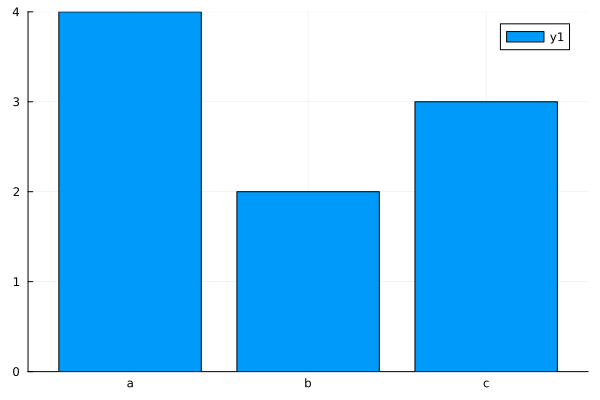

In [83]:
bar(["a", "b", "c"], [4,2,3])